In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as ptn
from plotnine import *
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances




In [64]:
df = pd.read_csv("base.csv", sep=";")
#df.head(10)
df.duplicated().sum()

0

In [65]:
# Limpieza de los datos

# Al analizar los datos, nos damos cuenta que no hay datos faltantes en el dataset, y tampoco hay variables que esten mal definidas en su tipo, por lo que tampoco hay que cambiar tipos de variables.

# Respecto a la edad, esta se encuentra en dias, y dado que comunmente se trabaja con la edad en anos, haremos la conversion a anos para que sea mas facil interpretar los resultados.
df["age"] = round(df["age"]/365, 1)
df = df.drop("id", axis=1)
#df.head(10)
df.duplicated().sum() # =665
df = df.drop_duplicates()

#Despues de eliminar la columna ID, verificamos si hay datos duplicados, con lo cual obtenemos un total de 665 registros duplicados, los cuales eliminaremos.

# Respecto al genero, este se encuentra como una variable categorica, donde se asigna un codigo, 1 o 2, para designar si la persona es hombre o mujer. Dado que de esta forma se hace mas facil trabajar para los modelos de clustering, sobre todo para K-Means, lo dejaremos tal cual.

#Luego hay varias variables tipo booleanos que se encuentran como variables int, donde se designa un 0 si es false, o un 1 si es true. Al igual que en el caso anterior, lo dejaremos asi debido a que nos facilitara el trabajo mas adelante.

# Para este trabajo, escogemos los modelos de clustering K-Means y DBScan

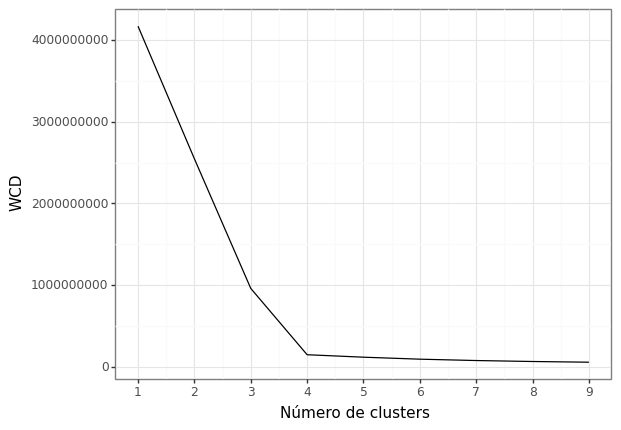

<ggplot: (137731492883)>

In [66]:
# K-Means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sse = []
n = 10
for i in range(1, n):

  km = KMeans(n_clusters = i)
  km.fit(df)
  sse.append(km.inertia_)
  
DataFrame=pd.DataFrame(range(1, n),columns=["n"])
DataFrame["sse"] = sse
(ggplot(DataFrame)+aes(x="n",y="sse")+theme_bw()+geom_line()+labs(x="Número de clusters",y="WCD")
  +scale_x_continuous(breaks=range(1,n)))



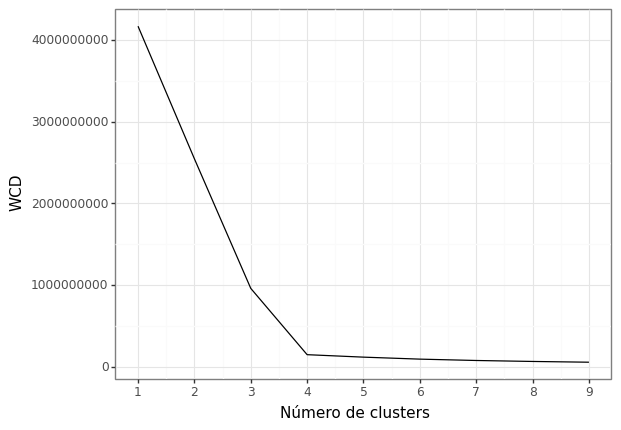

<ggplot: (137732157703)>

In [67]:
sse2 = []
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

for i in range(1, n):

  km2 = KMeans(n_clusters = i)
  km2.fit(df)
  sse2.append(km2.inertia_)
  
DataFrame2=pd.DataFrame(range(1, n),columns=["n"])
DataFrame2["sse"] = sse2
(ggplot(DataFrame2)+aes(x="n",y="sse")+theme_bw()+geom_line()+labs(x="Número de clusters",y="WCD")
  +scale_x_continuous(breaks=range(1,n)))

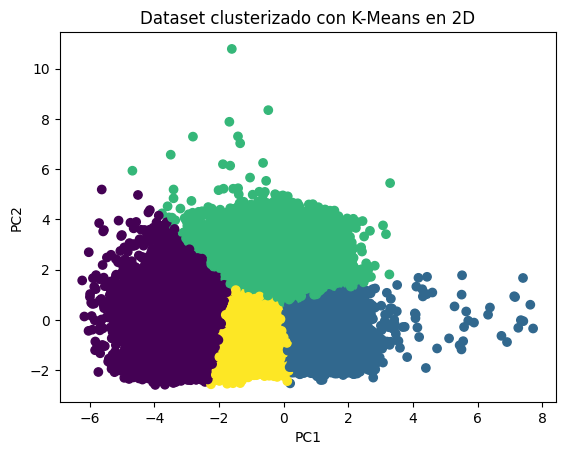

In [68]:
# Debido a los resultados obtenidos anteriormente, gracias al metodo del codo, elegimos fijar un numero de K = 4 clusters para este dataset

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Comenzamos aplicando PCA a los datos del dataset para poder graficarlos correctamente, y asi facilitar su interpretacion
pca = PCA(n_components=2)
pca = pca.fit(scaled_features)

# Luego creamos un dataset nuevo con los datos con el PCA aplicado
data = pca.transform(scaled_features)
data = pd.DataFrame(data, columns=["PC1","PC2"])
data.head(10)

# Aplicamos K-Means al dataset creado, y fijamos K = 4, obtenido anteriormente con el metodo del codo
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(data)
centroides = kmeans.cluster_centers_
etiquetas = kmeans.predict(data)

# Aca agregamos una columna al DataFrame con la etiqueta asignada por el algoritmo K-Means, para poder graficarlo
data = pd.DataFrame(np.concatenate((data, etiquetas.reshape(-1,1)), axis=1))
columnas = {0:"PC1", 1:"PC2", 2:"Cluster"}
data = data.rename(columns=columnas)
data.head(10)

colores = ["red", "green", "yellow", "blue"]

# Graficamos los datos clusterizados, separandolo por colores
plt.scatter(data["PC1"], data["PC2"], c=kmeans.labels_)
plt.title('Dataset clusterizado con K-Means en 2D')
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.show()


c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt


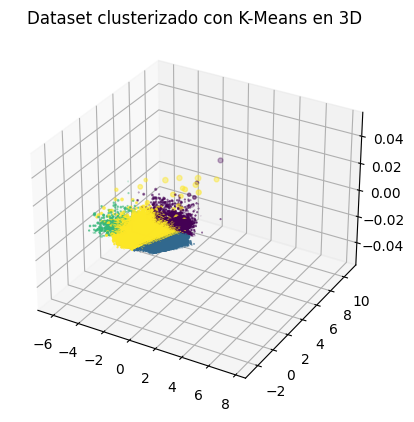

In [69]:
from mpl_toolkits.mplot3d import Axes3D

pca2 = PCA(n_components=3)
pca2 = pca2.fit(scaled_features)
data2 = pca2.transform(scaled_features)
data2 = pd.DataFrame(data2, columns=["PC1","PC2","PC3"])
data2.head(10)

kmeans2 = KMeans(n_clusters=4)
kmeans2 = kmeans2.fit(data2)
etiquetas2 = kmeans2.predict(data2)
data2 = pd.DataFrame(np.concatenate((data2, etiquetas2.reshape(-1,1)), axis=1))
columnas2 = {0:"PC1", 1:"PC2", 2:"PC3", 3:"Cluster"}
data2 = data2.rename(columns=columnas2)
colores = ["red", "green", "yellow","blue"]



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('Dataset clusterizado con K-Means en 3D')
plt.scatter(data2["PC1"], data2["PC2"], data2["PC3"], c=kmeans2.labels_)
plt.show()

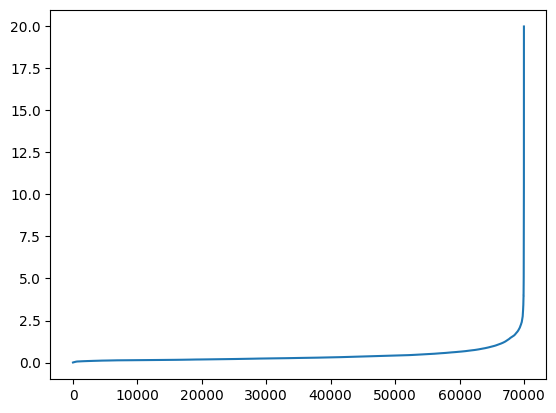

In [70]:
# DBScan
data4 = pd.read_csv("base.csv", sep=';')
# Extraemos los features y normalizamos
X = data4.iloc[:, 1:].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Graficamos con nearest neighbors para el metodo del codo y asi determinar epsilon, uno de los hiperparametros del algoritmo.
k = 5
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances[:,k], axis=0)
plt.plot(distances)
plt.show()


In [71]:
# Reducimos la dimensionalidad con PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X)
eps = 1.1 # Se escoje a partir del analisis del metodo del codo con Nearest Neighbors
# Debido a la gran cantidad de filas del dataset es inviable realizar el algoritmo DBSCAN con un valor superior a 1.1 en Google Colaboratory ya que excede la cantidad de RAM a disposicion.
# Es por esto que el valor de epsilon utilizado es lo mas cercano a 2 dentro de las limitaciones otorgadas por Colaboratory.
min_samples = 13 # Se elige a partir de la sugerencia vista en clases de Min_pts >= m+1 siendo m el numero de atributos que contienen los datos, que en este caso, son 12.
# No nos excedemos en min_samples debido a la capacidad limitada de Colaboratory en el caso de DBSCAN.
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)


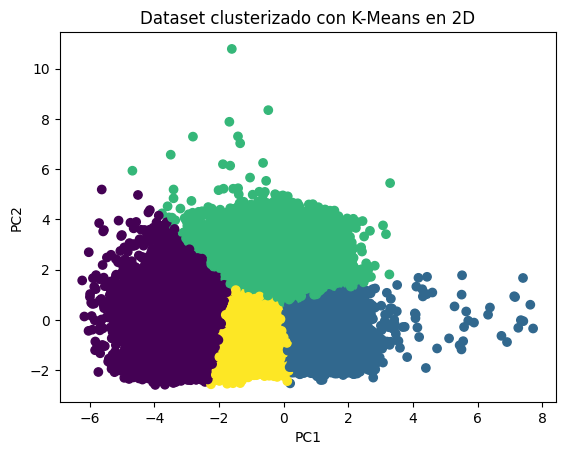

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt


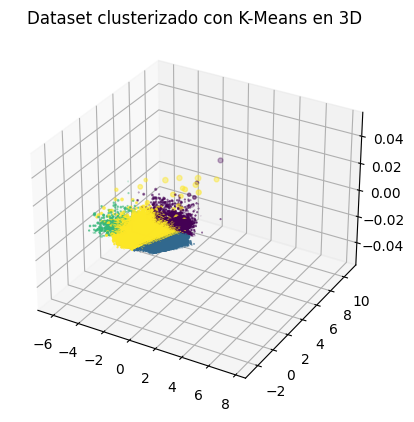

C:\Users\nicol\AppData\Local\Temp/ipykernel_14148/1309315373.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


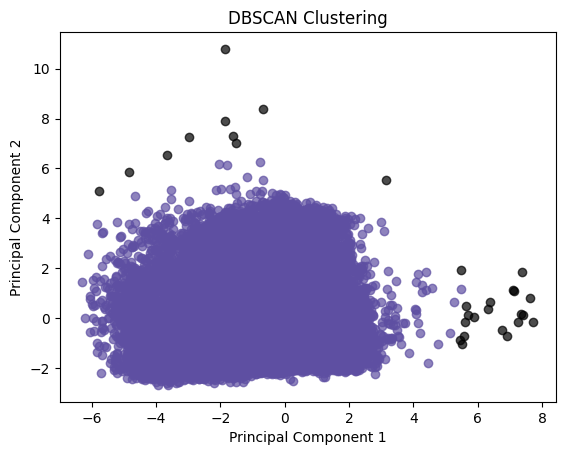

In [72]:
# Seleccion del modelo final

# Grafico K-Means 2D
plt.scatter(data["PC1"], data["PC2"], c=kmeans.labels_)
plt.title('Dataset clusterizado con K-Means en 2D')
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.show()

# Grafico K-Means 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('Dataset clusterizado con K-Means en 3D')
plt.scatter(data2["PC1"], data2["PC2"], data2["PC3"], c=kmeans2.labels_)
plt.show()

# Grafico DBScan
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for label, color in zip(unique_labels, colors):
    if label == -1:
        # Ocupamos el color negro para los puntos de ruido.
        color = 'k'
    class_member_mask = (labels == label)
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=color, alpha=0.7)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("DBSCAN Clustering")
plt.show()



# Al comparar la clusterizacion hecha en K-Means con DBScan, podemos notar claramente que K-Means entrega una clusterizacion bastante mas util, ya que separa claramente los datos en 4 clusters bien demarcados. En cambio, al aplicar DBScan, la clusterizacion resulto practicamente en un solo cluster enorme, donde estan casi todos los datos, y luego tenemos los datos outliers, por lo que la clusterizacion no ayuda a clasificar correctamente los datos del dataset. Es por esto que nuestra seleccion del modelo final sera la del modelo de K-Means.

In [91]:
# Renombrar columnas del dataset
columnas3 = []
dict = {}
n = 0
for i in df.columns:  
    columnas3.append(i)
    n += 1
for j in range(len(columnas3)):
    dict[j] = columnas3[j]
dict[12] = "Cluster"
df2 = pd.DataFrame(np.concatenate((df, etiquetas.reshape(-1,1)), axis=1))
df2 = df2.rename(columns=dict)



,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Cluster
0,50.4,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0
1,55.4,1.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,0.0,1.0,1.0,2.0
2,51.7,1.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0
3,48.3,2.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0
4,47.9,1.0,156.0,56.0,100.0,60.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,60.0,1.0,151.0,67.0,120.0,80.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0
6,60.6,1.0,157.0,93.0,130.0,80.0,3.0,1.0,0.0,0.0,1.0,0.0,2.0
7,61.9,2.0,178.0,95.0,130.0,90.0,3.0,3.0,0.0,0.0,1.0,1.0,2.0
8,48.4,1.0,158.0,71.0,110.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
9,54.3,1.0,164.0,68.0,110.0,60.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [96]:
# Analisis de los cluster del modelo final
cluster0 = df2[df2["Cluster"] == 0.0]
cluster1 = df2[df2["Cluster"] == 1.0]
cluster2 = df2[df2["Cluster"] == 2.0]
cluster3 = df2[df2["Cluster"] == 3.0]
cluster0.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Cluster
count,6681.000000,6681.000000,6681.000000,6681.000000,6681.000000,6681.000000,6681.000000,6681.000000,6681.000000,6681.000000,6681.000000,6681.000000,6681.0
mean,52.267131,1.974854,173.359976,84.661982,131.120790,113.315372,1.395749,1.210897,0.709924,0.381530,0.831313,0.549768,0.0
std,6.802026,0.156580,6.959090,16.924765,25.778924,293.992564,0.669887,0.523096,0.453831,0.485798,0.374504,0.497554,0.0
min,39.100000,1.000000,147.000000,22.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,47.400000,2.000000,169.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0
50%,52.300000,2.000000,173.000000,82.000000,130.000000,80.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0
75%,57.800000,2.000000,178.000000,94.000000,140.000000,90.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
max,64.800000,2.000000,250.000000,200.000000,1300.000000,10000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [97]:
cluster1.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Cluster
count,32525.000000,32525.000000,32525.000000,32525.000000,32525.000000,32525.000000,32525.000000,32525.000000,32525.000000,32525.000000,32525.000000,32525.000000,32525.0
mean,52.713962,1.027364,160.532544,68.638482,123.447686,86.278278,1.108347,1.053528,0.001261,0.002091,0.803136,0.401507,1.0
std,6.636545,0.163143,6.864849,11.312093,25.617472,80.080708,0.329455,0.257217,0.035483,0.045677,0.397635,0.490211,0.0
min,29.800000,1.000000,55.000000,10.000000,-140.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,48.000000,1.000000,156.000000,61.000000,115.000000,70.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0
50%,53.500000,1.000000,160.000000,68.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0
75%,57.900000,1.000000,165.000000,75.000000,130.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.0
max,64.900000,2.000000,180.000000,165.000000,1500.000000,1900.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [98]:
cluster2.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Cluster
count,12710.000000,12710.00000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.0
mean,57.070740,1.21251,162.413926,80.734017,145.556412,123.127695,2.384343,1.918489,0.019119,0.026436,0.791739,0.825413,2.0
std,5.492533,0.40910,7.355176,16.097186,356.949666,346.676242,0.753594,0.888883,0.136948,0.160434,0.406081,0.379628,0.0
min,39.100000,1.00000,75.000000,34.000000,10.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,53.900000,1.00000,158.000000,69.000000,120.000000,80.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.0
50%,57.900000,1.00000,163.000000,79.000000,130.000000,80.000000,3.000000,2.000000,0.000000,0.000000,1.000000,1.000000,2.0
75%,61.600000,1.00000,167.000000,90.000000,145.000000,90.000000,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000,2.0
max,64.900000,2.00000,195.000000,181.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.0


In [100]:
cluster3.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Cluster
count,17419.000000,17419.000000,17419.000000,17419.000000,17419.000000,17419.000000,17419.000000,17419.000000,17419.000000,17419.000000,17419.000000,17419.000000,17419.0
mean,52.202618,1.817728,169.474137,76.123291,126.069464,90.867731,1.108732,1.058212,0.065388,0.046558,0.798668,0.436305,3.0
std,6.913345,0.386080,6.063208,12.506810,24.600368,95.270964,0.341730,0.272455,0.247217,0.210697,0.401007,0.495941,0.0
min,29.600000,1.000000,120.000000,11.000000,-150.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,46.400000,2.000000,165.000000,68.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.0
50%,52.400000,2.000000,170.000000,75.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.0
75%,57.900000,2.000000,174.000000,84.000000,130.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,3.0
max,65.000000,2.000000,198.000000,165.000000,1409.000000,1200.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,3.0
